In [86]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from transformers import BarthezTokenizer, TFBartForSequenceClassification,BertTokenizer,TFBertForSequenceClassification
     

In [54]:
df=pd.read_csv('/Users/saisampath/professional/Gru_sentiment_analysis/auto-labelling (1).csv')
df.head()

,Product Description,Category,Uniq Id
0,"Sunny Isle Ylang Jamaican Black Castor Oil, 8 oz",Hair Care,c4fa57c1506c1fc7c42c853c73248dc2
1,"Crafted with organic aloe vera extracts, this ...",Hair Care,d14c60b116211fb6219d7d2b7e2293af
2,Eufora Beautifying Elixirs Bodifying Condition...,Hair Care,cd2cf57e9280a29f4a6cc5417d28231b
3,Indigo Powder:- The Indigo powder is made usin...,Hair Care,74ce49f475ddd0985ea41414b468be4b
4,Oil has been used for thousands of years for i...,Hair Care,a62fe6e3e986f0a75f9d9ed59c4dc1a8


In [88]:
def data_cleaning(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    return text


In [89]:
df["Product Description"]=df["Product Description"].apply(data_cleaning)

In [90]:
df["Category"].value_counts()

Category
Hair Care    100
Skin Care    100
Name: count, dtype: int64

In [91]:
df.isnull().sum()

Product Description    0
Category               0
Uniq Id                0
dtype: int64

In [57]:
df.duplicated().sum()

0

In [93]:
X = df['Product Description']
y = df['Category']

In [94]:
x_train,x_test,y_train,y_test= train_test_split(X,y,random_state=1,shuffle=True,test_size=0.30)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((140,), (60,), (140,), (60,))

### Creating the Gru For the sentimental analysis 

In [95]:
max_feature =10000 #max num of words to keep
max_len = 200 #max length of each sentence
embedding_dim = 128 #dimention of embedding vector 
batch_size = 2
epochs = 100

In [96]:
## Encoding the y_labels 
label_encoder=LabelEncoder()
y_train= label_encoder.fit_transform(y_train)
y_test=label_encoder.fit_transform(y_test)
y_test

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1])

In [66]:
y_train

array([0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 1])

In [114]:
# Tokenizing the text

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True,max_vocab_size=5000)


X_train_tokenized = tokenizer(
    x_train.values.tolist(),    # passing the data as a list to the tokenizer
    max_length=max_len,    # specifies the maximum length of the tokenized data
    padding='max_length',    # padding the data to the specified maximum length
    truncation=True,    # truncating the input if it is longer than the specified maximum length
    return_attention_mask=True,    # specifying to return attention masks
    return_tensors='tf',    # specifying to return the output as tensorflow tensors
)
X_test_tockenized=tokenizer(
    x_test.values.tolist(),
    max_length=max_len,
    padding="max_length",
    truncation=True,
    return_attention_mask=True,
    return_tensors='tf',
)

In [115]:
X_train_tokenized

{'input_ids': <tf.Tensor: shape=(140, 200), dtype=int32, numpy=
array([[  101,  1996,  4318, ...,  4309,  2099,   102],
       [  101, 16027,  3514, ...,     0,     0,     0],
       [  101, 11591,  9081, ...,     0,     0,     0],
       ...,
       [  101, 12992,  2115, ...,     0,     0,     0],
       [  101,  8875,  2828, ...,     0,     0,     0],
       [  101, 12098,  5289, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(140, 200), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(140, 200), dtype=int32, numpy=
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32

In [131]:
# Model definition
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=50000, output_dim=128, input_length=200),  # Add input_length
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
call_back = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.build(input_shape=(None, 200))  # Batch size is flexible (None), and each input sequence is 200 tokens long
model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_24 (Embedding)        │ (None, 200, 128)       │     6,400,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_48 (GRU)                    │ (None, 200, 128)       │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 200, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_49 (GRU)                    │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,538,945 (24.94 MB)

 Trainable params: 6,538,689 (24.94 MB)

 Non-trainable params: 256 (1.00 KB)

In [132]:
type(x_train)

pandas.core.series.Series

In [133]:
history = model.fit(
    X_train_tokenized['input_ids'],  # Only pass input_ids
    y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=(
        X_test_tockenized['input_ids'],  # Only pass input_ids
        y_test
    ),
    verbose=1,
    callbacks=[call_back]
)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.4697 - loss: 0.7795 - val_accuracy: 0.5000 - val_loss: 0.7028
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.4830 - loss: 0.7467 - val_accuracy: 0.5000 - val_loss: 0.7279
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.5398 - loss: 0.6973 - val_accuracy: 0.4500 - val_loss: 0.7221
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.7180 - loss: 0.4942 - val_accuracy: 0.4500 - val_loss: 0.8865


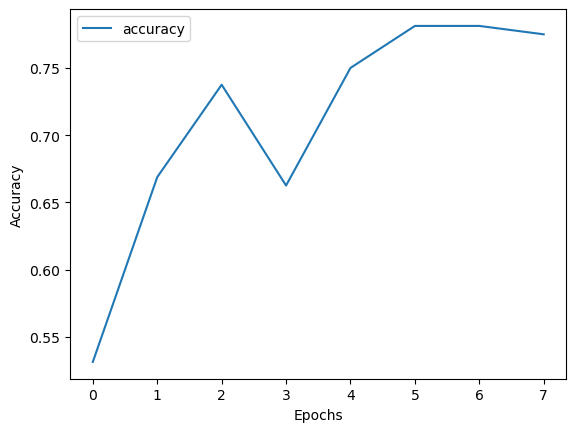

In [77]:
plt.plot(history.history.get('accuracy'))
# plt.plot(history.history.get('val_accuracy'))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'val_accuracy'])

In [136]:
loss, accuracy = model.evaluate( X_test_tockenized['input_ids'], y_test)
print(f"Test Accuracy: {accuracy:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.4250 - loss: 0.9054
Test Accuracy: 0.45


In [139]:
predictions = model.predict(X_test_tockenized["input_ids"])
predicted_labels = np.argmax(predictions, axis=1)
actual_labels = np.argmax(y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


In [140]:
predicted_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Epoch 1/10


/Users/saisampath/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.4951 - loss: 0.6941 - val_accuracy: 0.5250 - val_loss: 0.6931
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 0.4819 - loss: 0.6939 - val_accuracy: 0.4750 - val_loss: 0.6943
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.5236 - loss: 0.6935 - val_accuracy: 0.4750 - val_loss: 0.6942
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 0.5503 - loss: 0.6929 - val_accuracy: 0.4750 - val_loss: 0.6944
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 0.3933 - loss: 0.6969 - val_accuracy: 0.4750 - val_loss: 0.6936
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 0.5219 - loss: 0.6933 - val_accuracy: 0.4750 - val_loss: 0.6940
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.3362 - loss: 0.6964 - val_accuracy: 0.4750 - val_loss: 0.6935
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.4697 - loss: 0.6940 - val_accuracy: 0.4750 - val

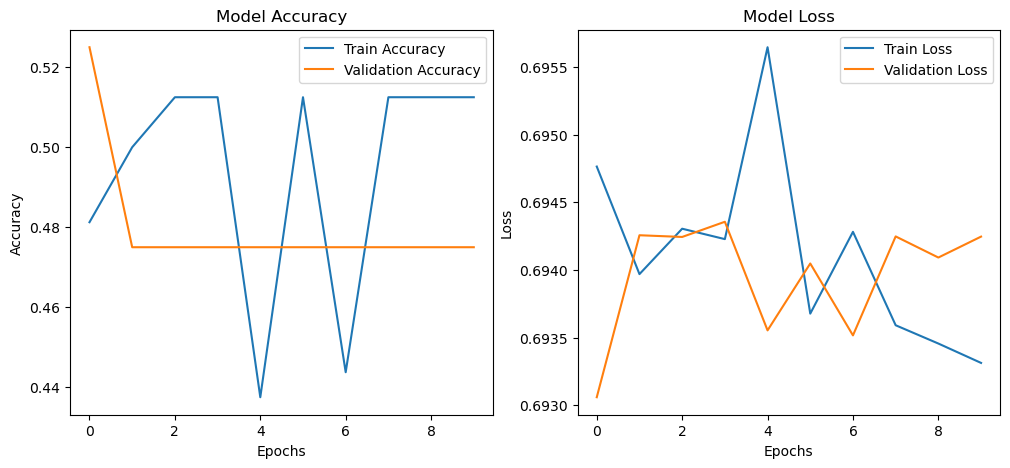

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step

Actual vs Predicted Categories:
Actual: Hair Care  |  Predicted: Skin Care
Actual: Hair Care  |  Predicted: Skin Care
Actual: Hair Care  |  Predicted: Skin Care
Actual: Skin Care  |  Predicted: Skin Care
Actual: Skin Care  |  Predicted: Skin Care
Actual: Skin Care  |  Predicted: Skin Care
Actual: Hair Care  |  Predicted: Skin Care
Actual: Skin Care  |  Predicted: Skin Care
Actual: Skin Care  |  Predicted: Skin Care
Actual: Hair Care  |  Predicted: Skin Care
Actual: Hair Care  |  Predicted: Skin Care
Actual: Skin Care  |  Predicted: Skin Care
Actual: Skin Care  |  Predicted: Skin Care
Actual: Hair Care  |  Predicted: Skin Care
Actual: Skin Care  |  Predicted: Skin Care
Actual: Skin Care  |  Predicted: Skin Care
Actual: Hair Care  |  Predicted: Skin Care
Actual: Skin Care  |  Predicted: Skin Care
Actual: Hair Care  |  Predicted: Skin Care
Actual: Hair Care  |  Predicted: Skin Care
Actual: Skin Care  |  Predicted: Skin Care
Actual: Hair Care  |  Pre

In [16]:
from tensorflow.keras.utils import to_categorical, plot_model
texts = df["Product Description"].values
labels = df["Category"].values

# Encode labels to numerical values
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Tokenization
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Split data
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels_categorical, test_size=0.2, random_state=42)

# Build the GRU model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=64, input_length=max_length),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

# Plot the model architecture
# plot_model(model, to_file="gru_model.png", show_shapes=True, show_layer_names=True)

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=2, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

# Get predictions
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
actual_labels = np.argmax(y_test, axis=1)

# Convert numerical predictions back to category names
predicted_categories = label_encoder.inverse_transform(predicted_labels)
actual_categories = label_encoder.inverse_transform(actual_labels)

# Print actual vs predicted results
print("\nActual vs Predicted Categories:")
for i in range(len(actual_categories)):
    print(f"Actual: {actual_categories[i]}  |  Predicted: {predicted_categories[i]}")


In [141]:
df

,Product Description,Category,Uniq Id
0,sunny isle ylang jamaican black castor oil oz,Hair Care,c4fa57c1506c1fc7c42c853c73248dc2
1,crafted with organic aloe vera extracts this s...,Hair Care,d14c60b116211fb6219d7d2b7e2293af
2,eufora beautifying elixirs bodifying condition...,Hair Care,cd2cf57e9280a29f4a6cc5417d28231b
3,indigo powder the indigo powder is made using ...,Hair Care,74ce49f475ddd0985ea41414b468be4b
4,oil has been used for thousands of years for i...,Hair Care,a62fe6e3e986f0a75f9d9ed59c4dc1a8
...,...,...,...
195,item type treatment mask gender unisex featur...,Skin Care,5dafb894e2772b5a57b639925c036b13
196,this brushs soft synthetic bristles pick up an...,Skin Care,b76bd3f0de8c2055e8f709d0e8f9ae15
197,model number pc size as the picture shows typ...,Skin Care,92d624118d4b5b6228eb4be9e871c564
198,bentonite clay draws toxins from the skin and ...,Skin Care,f3dd556275ef7c5cac564f04cc1ce23d


In [150]:
from tensorflow.keras.layers import  Dense,TextVectorization,Embedding,Input
x_train,x_val,y_train,y_val= train_test_split(X,y, random_state=1,test_size=0.30, shuffle=True,stratify=y)

In [151]:
text_vector= TextVectorization(max_tokens=5000,output_sequence_length=200,output_mode="int")
text_vector.adapt(x_train)

In [160]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vector(inputs)
x = Embedding(input_dim=50000,output_dim=128)(x)  # Adjust output_dim as needed
x=tf.keras.layers.GRU(128, return_sequences=True)(x)
x=tf.keras.layers.GRU(64)(x)
x= tf.keras.layers.Dense(32, activation='tanh')(x)
outputs= tf.keras.layers.Dense(1, activation='softmax')(x)
model_2 = tf.keras.Model(inputs, outputs)
model_2.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 200)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_30 (Embedding)        │ (None, 200, 128)       │     6,400,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_60 (GRU)                    │ (None, 200, 128)       │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_61 (GRU)                    │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,538,433 (24.94 MB)

 Trainable params: 6,538,433 (24.94 MB)

 Non-trainable params: 0 (0.00 B)

In [161]:
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [162]:
model_2_history=model_2.fit(
    x_train,
    y_train,
    epochs=5,
    validation_data=(x_val,y_val))

Epoch 1/5


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 275ms/step - accuracy: 0.5139 - loss: 0.6943 - val_accuracy: 0.5000 - val_loss: 0.6937
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 0.5204 - loss: 0.6902 - val_accuracy: 0.5000 - val_loss: 0.6949
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 0.5009 - loss: 0.6950 - val_accuracy: 0.5000 - val_loss: 0.6963
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - accuracy: 0.4774 - loss: 0.6916 - val_accuracy: 0.5000 - val_loss: 0.6939
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - accuracy: 0.4661 - loss: 0.6896 - val_accuracy: 0.5000 - val_loss: 0.6931


In [156]:
y_val=label_encoder.fit_transform(y_val)
y_train=label_encoder.fit_transform(y_train)

In [158]:
y_val

array([0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0])